In [1]:
import os
import random

import scipy as sp
import numpy as np
import pandas as pd
import antropy as ant
import seaborn as sns
import matplotlib.pyplot as plt

from tsfresh import extract_relevant_features

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,  GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import f1_score

In [2]:
# define helper functions:

def convertToRealValue(x):
    """ as suggested in the README.txt file """
    
    return -14.709 + (x/63)*(2*14.709)


def loadOne(filePath):
    """ load one record """

    data = pd.read_csv(filePath, sep=" ", header=None)

    return data


def preProcessOne(dfRaw):
    """ pre-process one record """

    dfRaw.columns = ["x", "y", "z"] # define column names
    dfRaw.index = dfRaw.index / fs  # convert index to seconds

    # convert mapped data to accelerometer real-values
    dfReal = dfRaw.applymap(lambda x: convertToRealValue(x))

    # apply median filter to smooth possible artifacts:
    dfSmooth = dfReal.rolling(3, center=True).median()

    return dfSmooth.dropna()


def plotOne(df, title=None, ax=None):
    """ plot time series for one record """

    df.plot(ax=ax)
    plt.xlabel("time [s]")
    plt.ylabel("acceleration [$m/s^2$]")

    if title:
        plt.title(title)

        
def slopeAndIntercept(x, y):
    """ compute slope and intercept of signal y (x is time) """

    slope, intercept, _, _, _ = sp.stats.linregress(x, y)

    return slope, intercept


def featuresExtraction(df, fs):
    """ extract a number of features characterizing the x,y,z accelerometer's signals (will return a pd.Series) """

    # compute features
    featuresDict = {
        "mean": df.mean(skipna=True).to_dict(),
        "median": df.median(skipna=True).to_dict(),
        "mode": df.mode().T.to_dict()[0],
        "std": df.std(skipna=True).to_dict(),
        "sem": df.sem(skipna=True).to_dict(),
        "sum": df.sum(skipna=True).to_dict(),
        "min": df.min(skipna=True).to_dict(),
        "max": df.max(skipna=True).to_dict(),
        "kurtosis": df.kurtosis(skipna=True).to_dict(),
        "skewness": df.skew(skipna=True).to_dict(),
        "mad": df.mad(skipna=True).to_dict(),
        "IQR": (df.quantile(q=0.75) - df.quantile(q=0.25)).to_dict(),
        "lineLength": df.diff().abs().sum().to_dict(),
        "energy": df.abs().applymap(lambda x: x**2).sum().to_dict(),
        "permEntropy": {k: ant.perm_entropy(df[k], normalize=True) for k in ['x', 'y', 'z']},
        "specEntropy": {k: ant.spectral_entropy(df[k], sf=fs, method='welch', normalize=True) for k in ['x', 'y', 'z']},
        "svdEntropy": {k: ant.svd_entropy(df[k], normalize=True) for k in ['x', 'y', 'z']},
        "sampleEntropy": {k: ant.sample_entropy(df[k]) for k in ['x', 'y', 'z']},
        "hjorthMobility": {k: ant.hjorth_params(df[k])[0] for k in ['x', 'y', 'z']},
        "hjorthComplexity": {k: ant.hjorth_params(df[k])[1] for k in ['x', 'y', 'z']},
        "petrosianFractDim": {k: ant.petrosian_fd(df[k]) for k in ['x', 'y', 'z']},
        "higuchiFractDim": {k: ant.higuchi_fd(df[k]) for k in ['x', 'y', 'z']},
        "dfa": {k: ant.detrended_fluctuation(df[k]) for k in ['x', 'y', 'z']},
        "cv": {k: sp.stats.variation(df[k], nan_policy='omit') for k in ['x', 'y', 'z']},
        "shapiro": {k: sp.stats.shapiro(df[k])[0] for k in ['x', 'y', 'z']},
        "slope": {k: slopeAndIntercept(x=df.index, y=df[k])[0] for k in ['x', 'y', 'z']},
        "intercept": {k: slopeAndIntercept(x=df.index, y=df[k])[1] for k in ['x', 'y', 'z']},
    }

    stretchedFeaturesDict = {f"{feat}_{ch}": featuresDict[feat][ch] for feat in featuresDict for ch in ['x', 'y', 'z']}

    return pd.Series(stretchedFeaturesDict)



def buildFeaturesDataMatrix(srcDir):
    """ stack features' vectors of all records into a unique matrix (will return a pd.DataFrame) """

    activities = os.listdir(srcDir)
    
    allRecsVectors = []
    for activity in activities:
        for recName in os.listdir(os.path.join(srcDir, activity)):
            print(f"{activity}: {recName}")
            df = loadOne(filePath=os.path.join(srcDir, activity, recName))
            df = preProcessOne(dfRaw=df)
            ftsVector = featuresExtraction(df, fs)
            ftsVector = ftsVector.append(pd.Series({"activity": activity}))
            allRecsVectors.append(ftsVector)

    dfDataMatrix = pd.concat(allRecsVectors, axis=1, ignore_index=True).T

    print(f" == buildFeaturesDataMatrix: COMPLETE (Tot: {len(dfDataMatrix)} records) == ")
    
    return dfDataMatrix


def buildFeaturesDataMatrixUsingTSFresh(srcDir):
    """ use tsfresh to automatically extract and select features characterizing time series """
    
    activities = os.listdir(srcDir)

    dfRecordsLst, recNamesLst, recIdLst, recTrueActivityLst = [], [], [], []
    recID = 0
    for activity in activities:
        for recName in os.listdir(os.path.join(srcDir, activity)):
            print(f"{activity}: {recName}")
            recNamesLst.append(recName)
            recIdLst.append(recID)
            recTrueActivityLst.append(activity)
            df = loadOne(filePath=os.path.join(srcDir, activity, recName))
            df = preProcessOne(dfRaw=df)
            df['recordName'] = recName
            df['recordID'] = recID
            df['activity'] = activity
            df['time'] = df.index
            df.index = [x for x in range(len(df))]
            dfRecordsLst.append(df)
            recID += 1

    dfAllRecs = pd.concat(dfRecordsLst, axis=0, ignore_index=True)

    # prepare data for tsfresh, extract relevant features, append activity label:
    dfTimeseries = dfAllRecs.drop(labels=['recordName', 'activity'], axis=1)
    serTrueLabels = pd.Series(recTrueActivityLst, index=recIdLst)
    dfDataMatrix = extract_relevant_features(dfTimeseries, serTrueLabels, column_id="recordID", column_sort="time")
    dfDataMatrix['activity'] = recTrueActivityLst

    return dfDataMatrix


def plotTSNE(X, y):
    """ plot dataset 2D t-distributed stochastic neighbors embedding representation """

    tSNE = TSNE(learning_rate=200)
    transformed = tSNE.fit_transform(X)
    dfTSNE = pd.DataFrame({'tSNE_1': transformed[:, 0], 'tSNE_2': transformed[:, 1], 'activity': y})
    sns.set_style("white")
    plt.figure()
    sns.scatterplot(data=dfTSNE, x='tSNE_1', y='tSNE_2', hue='activity')
    plt.xlabel('t-SNE 1-st component'), plt.ylabel('t-SNE 2-nd component')
    plt.title("t-distributed Stochastic Neighbors Embedding", fontweight='bold')

    
        
def plotConfusionMatrix(y_test, y_pred):
    """ plot confusion matrix for the predicted labels """

    df = pd.DataFrame({"predicted_label": y_pred, "true_label": y_test})
    ct = pd.crosstab(df['predicted_label'], df['true_label'])

    kwsHeat = {
        'annot': True,
        'cbar': False,
        'square': True,
        'xticklabels': True,
        'yticklabels': True,
        'linewidths': .1,
        'fmt': 'd',
        'cmap': 'YlGnBu', 
    }

    plt.figure()
    ax = sns.heatmap(ct, **kwsHeat)
    ax.tick_params(axis='both', which='both', labelsize=8)
    ax.set_xlabel('True Label', fontweight='bold')
    ax.set_ylabel('Predicted Label', fontweight='bold')

    
def f1ScoreClassifiers(X_train, X_test, y_train, y_test, classifiersLst, confusionMatrix=False):
    """ train and test all classifiers in classifiersLst and evaluate their performance using F1-score """

    for clf in classifiersLst:

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        f1Score = f1_score(y_true=y_test, y_pred=y_pred, average="macro")

        print(f"F1-Score: {round(f1Score, 3)},  Classifier: {clf.__class__.__name__}")

        if confusionMatrix:

            plotConfusionMatrix(y_test, y_pred)
            plt.title(f"{clf.__class__.__name__}")

            
def f1ScoreEnsembleClassifier(X_train, X_test, y_train, y_test, classifiersTuplesLst):
    """ build, train and test ensemble classifier stacking the best individual classifiers """

    clf = StackingClassifier(
        estimators=classifiersTuplesLst,
        final_estimator=GradientBoostingClassifier()
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    f1Score = f1_score(y_true=y_test, y_pred=y_pred, average="macro")

    print(f"Ensemble Classifier F1-Score: {round(f1Score, 3)}")

In [3]:
# define general variables:
srcDir = r"...\biometricData\accelerometer\UCI-humanMotionPrimitives\data"  
fs = 32

In [4]:
# define general variables:
srcDir = r"C:\CodeRug\biometricData\accelerometer\UCI-humanMotionPrimitives\data"  # put here directory storing data
fs = 32

# get list of classes:
activities = os.listdir(srcDir)
for activity in activities:
    print(activity)

climb_stairs
comb_hair
descend_stairs
drink_glass
getup_bed
liedown_bed
pour_water
sitdown_chair
standup_chair
walk


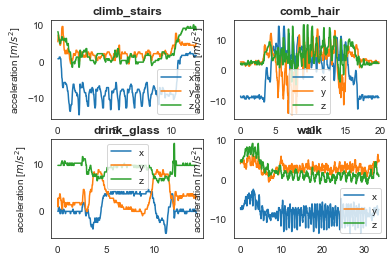

In [5]:
    # plot 4 records as example: 
    sns.set_style("white")
    for i, activity in enumerate(['climb_stairs', 'comb_hair', 'drink_glass', 'walk']):
        fileName = random.choice(os.listdir(os.path.join(srcDir, activity)))
        df = loadOne(filePath=os.path.join(srcDir, activity, fileName))
        df = preProcessOne(dfRaw=df)
        ax = plt.subplot(2, 2, i + 1)
        plotOne(df, ax=ax)
        ax.set_title(activity, fontweight='bold')
        ax.set_xlabel('')

In [6]:
# load all time series, extract features, store all in a matrix 
dataMatrix = buildFeaturesDataMatrix(srcDir)

climb_stairs: Accelerometer-2011-03-24-10-24-39-climb_stairs-f1.txt
climb_stairs: Accelerometer-2011-03-24-10-25-44-climb_stairs-f1.txt
climb_stairs: Accelerometer-2011-03-29-09-55-46-climb_stairs-f1.txt
climb_stairs: Accelerometer-2011-04-05-18-21-22-climb_stairs-f1.txt
climb_stairs: Accelerometer-2011-04-05-18-32-29-climb_stairs-f1.txt
climb_stairs: Accelerometer-2011-04-11-11-44-35-climb_stairs-f1.txt
climb_stairs: Accelerometer-2011-04-11-11-57-50-climb_stairs-f1.txt
climb_stairs: Accelerometer-2011-04-11-11-58-30-climb_stairs-f1.txt
climb_stairs: Accelerometer-2011-05-30-08-21-38-climb_stairs-f1.txt
climb_stairs: Accelerometer-2011-05-30-08-30-37-climb_stairs-f1.txt


C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 193, using nperseg = 193
  .format(nperseg, input_length))


climb_stairs: Accelerometer-2011-05-30-08-39-09-climb_stairs-f1.txt
climb_stairs: Accelerometer-2011-05-30-09-29-58-climb_stairs-f1.txt
climb_stairs: Accelerometer-2011-05-30-09-38-52-climb_stairs-f1.txt
climb_stairs: Accelerometer-2011-05-30-09-43-37-climb_stairs-f1.txt
climb_stairs: Accelerometer-2011-05-30-10-20-47-climb_stairs-m1.txt
climb_stairs: Accelerometer-2011-05-30-10-32-53-climb_stairs-m1.txt
climb_stairs: Accelerometer-2011-05-30-10-41-10-climb_stairs-m1.txt
climb_stairs: Accelerometer-2011-05-30-20-54-39-climb_stairs-f1.txt
climb_stairs: Accelerometer-2011-05-30-21-02-43-climb_stairs-f1.txt
climb_stairs: Accelerometer-2011-05-30-21-14-55-climb_stairs-f1.txt
climb_stairs: Accelerometer-2011-05-30-21-36-58-climb_stairs-m2.txt
climb_stairs: Accelerometer-2011-05-30-21-46-05-climb_stairs-m2.txt
climb_stairs: Accelerometer-2011-05-30-22-00-32-climb_stairs-m2.txt
climb_stairs: Accelerometer-2011-05-31-14-58-41-climb_stairs-f1.txt
climb_stairs: Accelerometer-2011-05-31-15-06-32-

C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 164, using nperseg = 164
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 214, using nperseg = 214
  .format(nperseg, input_length))


climb_stairs: Accelerometer-2011-06-06-11-00-50-climb_stairs-f1.txt
climb_stairs: Accelerometer-2011-06-06-11-01-27-climb_stairs-f1.txt
climb_stairs: Accelerometer-2011-06-06-11-02-24-climb_stairs-f1.txt
climb_stairs: Accelerometer-2012-05-28-17-56-03-climb_stairs-m1.txt
climb_stairs: Accelerometer-2012-05-28-17-56-40-climb_stairs-m1.txt
climb_stairs: Accelerometer-2012-05-29-16-53-12-climb_stairs-f2.txt
climb_stairs: Accelerometer-2012-05-29-16-54-38-climb_stairs-f2.txt
climb_stairs: Accelerometer-2012-05-29-17-17-05-climb_stairs-m3.txt
climb_stairs: Accelerometer-2012-05-29-17-17-51-climb_stairs-m3.txt
climb_stairs: Accelerometer-2012-05-30-18-31-08-climb_stairs-f3.txt
climb_stairs: Accelerometer-2012-05-30-18-31-52-climb_stairs-f3.txt
climb_stairs: Accelerometer-2012-05-30-18-32-56-climb_stairs-f3.txt
climb_stairs: Accelerometer-2012-05-30-18-33-57-climb_stairs-f3.txt
climb_stairs: Accelerometer-2012-05-30-19-12-19-climb_stairs-m4.txt
climb_stairs: Accelerometer-2012-05-30-19-12-57-

C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 251, using nperseg = 251
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 253, using nperseg = 253
  .format(nperseg, input_length))


climb_stairs: Accelerometer-2012-06-06-14-12-49-climb_stairs-m7.txt
climb_stairs: Accelerometer-2012-06-06-14-13-05-climb_stairs-m7.txt
climb_stairs: Accelerometer-2012-06-06-14-13-20-climb_stairs-m7.txt
climb_stairs: Accelerometer-2012-06-07-10-48-08-climb_stairs-f1.txt
climb_stairs: Accelerometer-2012-06-07-10-48-24-climb_stairs-f1.txt
climb_stairs: Accelerometer-2012-06-07-10-49-17-climb_stairs-f1.txt
climb_stairs: Accelerometer-2012-06-07-10-49-35-climb_stairs-f1.txt
climb_stairs: Accelerometer-2012-06-07-10-53-34-climb_stairs-f1.txt
climb_stairs: Accelerometer-2012-06-07-10-53-53-climb_stairs-f1.txt
climb_stairs: Accelerometer-2012-06-07-10-54-12-climb_stairs-f1.txt
climb_stairs: Accelerometer-2012-06-07-10-54-29-climb_stairs-f1.txt
comb_hair: Accelerometer-2011-03-24-09-44-34-comb_hair-f1.txt
comb_hair: Accelerometer-2011-03-24-10-26-33-comb_hair-f1.txt
comb_hair: Accelerometer-2011-03-24-10-57-40-comb_hair-f1.txt
comb_hair: Accelerometer-2011-03-24-16-10-36-comb_hair-f2.txt
comb

C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 254, using nperseg = 254
  .format(nperseg, input_length))


descend_stairs: Accelerometer-2011-03-29-16-18-14-descend_stairs-f1.txt
descend_stairs: Accelerometer-2011-04-05-18-26-06-descend_stairs-f1.txt
descend_stairs: Accelerometer-2011-04-11-11-51-27-descend_stairs-f1.txt
descend_stairs: Accelerometer-2011-04-11-13-32-24-descend_stairs-f1.txt
descend_stairs: Accelerometer-2011-05-30-08-20-55-descend_stairs-f1.txt
descend_stairs: Accelerometer-2011-05-30-08-24-58-descend_stairs-f1.txt
descend_stairs: Accelerometer-2011-05-30-08-34-06-descend_stairs-f1.txt
descend_stairs: Accelerometer-2011-05-30-09-29-15-descend_stairs-f1.txt
descend_stairs: Accelerometer-2011-05-30-09-31-43-descend_stairs-f1.txt
descend_stairs: Accelerometer-2011-05-30-09-40-50-descend_stairs-f1.txt
descend_stairs: Accelerometer-2011-05-30-10-19-56-descend_stairs-m1.txt
descend_stairs: Accelerometer-2011-05-30-10-24-51-descend_stairs-m1.txt
descend_stairs: Accelerometer-2011-05-30-10-37-30-descend_stairs-m1.txt
descend_stairs: Accelerometer-2011-05-30-20-48-10-descend_stairs

C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 254, using nperseg = 254
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 232, using nperseg = 232
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 154, using nperseg = 154
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 188, using nperseg = 188
  .format(nperseg, input_length))


drink_glass: Accelerometer-2011-03-24-10-46-25-drink_glass-f1.txt
drink_glass: Accelerometer-2011-03-24-11-14-00-drink_glass-f1.txt
drink_glass: Accelerometer-2011-03-24-13-09-29-drink_glass-f1.txt
drink_glass: Accelerometer-2011-03-24-13-17-06-drink_glass-f1.txt
drink_glass: Accelerometer-2011-03-24-13-31-22-drink_glass-f1.txt
drink_glass: Accelerometer-2011-03-24-16-08-10-drink_glass-f2.txt
drink_glass: Accelerometer-2011-03-24-16-08-29-drink_glass-f2.txt
drink_glass: Accelerometer-2011-04-05-18-55-33-drink_glass-f1.txt
drink_glass: Accelerometer-2011-04-08-17-33-35-drink_glass-f3.txt
drink_glass: Accelerometer-2011-04-08-17-35-00-drink_glass-f3.txt
drink_glass: Accelerometer-2011-04-08-18-10-09-drink_glass-m4.txt
drink_glass: Accelerometer-2011-04-11-12-55-39-drink_glass-f1.txt
drink_glass: Accelerometer-2011-04-11-13-17-55-drink_glass-f1.txt
drink_glass: Accelerometer-2011-04-12-21-43-48-drink_glass-m8.txt
drink_glass: Accelerometer-2011-04-12-21-44-55-drink_glass-m8.txt
drink_glas

C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 253, using nperseg = 253
  .format(nperseg, input_length))


drink_glass: Accelerometer-2011-06-01-14-13-57-drink_glass-f1.txt
drink_glass: Accelerometer-2011-06-01-14-14-22-drink_glass-f1.txt
drink_glass: Accelerometer-2011-06-01-14-14-49-drink_glass-f1.txt
drink_glass: Accelerometer-2011-06-01-14-15-19-drink_glass-f1.txt
drink_glass: Accelerometer-2011-06-01-14-15-49-drink_glass-f1.txt
drink_glass: Accelerometer-2011-06-01-14-20-46-drink_glass-f1.txt
drink_glass: Accelerometer-2011-06-01-14-21-52-drink_glass-f1.txt
drink_glass: Accelerometer-2011-06-01-14-23-15-drink_glass-f1.txt
drink_glass: Accelerometer-2011-06-01-14-24-51-drink_glass-f1.txt
drink_glass: Accelerometer-2011-06-01-14-28-50-drink_glass-f1.txt
drink_glass: Accelerometer-2011-06-01-14-30-43-drink_glass-f1.txt
drink_glass: Accelerometer-2011-06-01-14-33-59-drink_glass-f1.txt
drink_glass: Accelerometer-2011-06-01-15-04-40-drink_glass-f1.txt
drink_glass: Accelerometer-2011-06-01-15-09-37-drink_glass-f1.txt
drink_glass: Accelerometer-2011-06-01-15-14-42-drink_glass-f1.txt
drink_glas

C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 255, using nperseg = 255
  .format(nperseg, input_length))


getup_bed: Accelerometer-2011-05-30-08-38-15-getup_bed-f1.txt
getup_bed: Accelerometer-2011-05-30-09-33-26-getup_bed-f1.txt
getup_bed: Accelerometer-2011-05-30-09-42-46-getup_bed-f1.txt
getup_bed: Accelerometer-2011-05-30-10-27-01-getup_bed-m1.txt
getup_bed: Accelerometer-2011-05-30-10-39-27-getup_bed-m1.txt
getup_bed: Accelerometer-2011-05-30-20-53-40-getup_bed-f1.txt
getup_bed: Accelerometer-2011-05-30-20-59-57-getup_bed-f1.txt
getup_bed: Accelerometer-2011-05-30-21-13-57-getup_bed-f1.txt
getup_bed: Accelerometer-2011-05-30-21-36-01-getup_bed-m2.txt
getup_bed: Accelerometer-2011-05-30-21-42-30-getup_bed-m2.txt
getup_bed: Accelerometer-2011-05-30-21-59-46-getup_bed-m2.txt
getup_bed: Accelerometer-2011-05-31-14-57-24-getup_bed-f1.txt
getup_bed: Accelerometer-2011-05-31-15-02-55-getup_bed-f1.txt
getup_bed: Accelerometer-2011-05-31-15-19-41-getup_bed-f1.txt
getup_bed: Accelerometer-2011-05-31-16-25-09-getup_bed-f1.txt
getup_bed: Accelerometer-2011-05-31-16-30-18-getup_bed-f1.txt
getup_be

C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 254, using nperseg = 254
  .format(nperseg, input_length))


getup_bed: Accelerometer-2012-05-28-17-52-54-getup_bed-m1.txt
getup_bed: Accelerometer-2012-05-28-17-53-29-getup_bed-m1.txt
getup_bed: Accelerometer-2012-05-28-17-54-04-getup_bed-m1.txt
getup_bed: Accelerometer-2012-05-28-17-54-37-getup_bed-m1.txt
getup_bed: Accelerometer-2012-05-28-17-55-04-getup_bed-m1.txt
getup_bed: Accelerometer-2012-05-30-21-51-41-getup_bed-m2.txt
getup_bed: Accelerometer-2012-05-30-21-52-18-getup_bed-m2.txt
getup_bed: Accelerometer-2012-05-30-21-53-05-getup_bed-m2.txt
getup_bed: Accelerometer-2012-05-30-21-53-38-getup_bed-m2.txt
getup_bed: Accelerometer-2012-05-30-21-54-12-getup_bed-m2.txt
getup_bed: Accelerometer-2012-06-07-22-15-16-getup_bed-f4.txt
getup_bed: Accelerometer-2012-06-07-22-16-05-getup_bed-f4.txt
getup_bed: Accelerometer-2012-06-07-22-16-42-getup_bed-f4.txt
getup_bed: Accelerometer-2012-06-07-22-17-45-getup_bed-f4.txt
getup_bed: Accelerometer-2012-06-07-22-19-25-getup_bed-f4.txt
getup_bed: Accelerometer-2012-06-07-22-20-59-getup_bed-f4.txt
getup_be

C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 210, using nperseg = 210
  .format(nperseg, input_length))


liedown_bed: Accelerometer-2011-05-30-08-37-27-liedown_bed-f1.txt
liedown_bed: Accelerometer-2011-05-30-09-32-42-liedown_bed-f1.txt
liedown_bed: Accelerometer-2011-05-30-09-41-49-liedown_bed-f1.txt
liedown_bed: Accelerometer-2011-05-30-10-26-14-liedown_bed-m1.txt
liedown_bed: Accelerometer-2011-05-30-10-38-41-liedown_bed-m1.txt
liedown_bed: Accelerometer-2011-05-30-20-52-31-liedown_bed-f1.txt
liedown_bed: Accelerometer-2011-05-30-20-59-04-liedown_bed-f1.txt
liedown_bed: Accelerometer-2011-05-30-21-13-15-liedown_bed-f1.txt
liedown_bed: Accelerometer-2011-05-30-21-35-19-liedown_bed-m2.txt
liedown_bed: Accelerometer-2011-05-30-21-41-32-liedown_bed-m2.txt
liedown_bed: Accelerometer-2011-05-30-21-59-16-liedown_bed-m2.txt
liedown_bed: Accelerometer-2011-05-31-14-56-04-liedown_bed-f1.txt
liedown_bed: Accelerometer-2011-05-31-15-02-19-liedown_bed-f1.txt
liedown_bed: Accelerometer-2011-05-31-15-18-50-liedown_bed-f1.txt
liedown_bed: Accelerometer-2011-05-31-16-24-36-liedown_bed-f1.txt
liedown_be

C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 242, using nperseg = 242
  .format(nperseg, input_length))


pour_water: Accelerometer-2012-05-30-18-27-41-pour_water-f3.txt
pour_water: Accelerometer-2012-05-30-19-07-14-pour_water-m4.txt
pour_water: Accelerometer-2012-05-30-19-07-43-pour_water-m4.txt
pour_water: Accelerometer-2012-05-30-19-08-20-pour_water-m4.txt
pour_water: Accelerometer-2012-05-30-19-08-50-pour_water-m4.txt
pour_water: Accelerometer-2012-05-30-19-50-42-pour_water-f2.txt
pour_water: Accelerometer-2012-05-30-19-52-29-pour_water-f2.txt
pour_water: Accelerometer-2012-05-30-19-54-24-pour_water-f2.txt
pour_water: Accelerometer-2012-05-30-19-56-40-pour_water-m3.txt
pour_water: Accelerometer-2012-05-30-19-57-40-pour_water-m3.txt
pour_water: Accelerometer-2012-05-30-19-59-17-pour_water-m3.txt
pour_water: Accelerometer-2012-06-07-21-27-46-pour_water-f4.txt
pour_water: Accelerometer-2012-06-07-21-28-23-pour_water-f4.txt
pour_water: Accelerometer-2012-06-07-21-28-48-pour_water-f4.txt
pour_water: Accelerometer-2012-06-07-21-29-09-pour_water-f4.txt
pour_water: Accelerometer-2012-06-07-21-

C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 153, using nperseg = 153
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 199, using nperseg = 199
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 129, using nperseg = 129
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 191, using nperseg = 191
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is gre

sitdown_chair: Accelerometer-2011-04-08-17-34-35-sitdown_chair-f3.txt
sitdown_chair: Accelerometer-2011-04-08-18-09-40-sitdown_chair-m4.txt
sitdown_chair: Accelerometer-2011-04-11-11-45-28-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-04-12-21-42-24-sitdown_chair-m8.txt
sitdown_chair: Accelerometer-2011-04-12-21-43-15-sitdown_chair-m8.txt
sitdown_chair: Accelerometer-2011-05-30-08-22-28-sitdown_chair-f1.txt


C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 172, using nperseg = 172
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 153, using nperseg = 153
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 175, using nperseg = 175
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 156, using nperseg = 156
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is gre

sitdown_chair: Accelerometer-2011-05-30-08-31-30-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-05-30-09-23-12-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-05-30-09-24-48-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-05-30-10-21-50-sitdown_chair-m1.txt
sitdown_chair: Accelerometer-2011-05-30-10-31-12-sitdown_chair-m1.txt
sitdown_chair: Accelerometer-2011-05-30-20-48-57-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-05-30-20-49-32-sitdown_chair-f1.txt


C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 123, using nperseg = 123
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 156, using nperseg = 156
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 198, using nperseg = 198
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 178, using nperseg = 178
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is gre

sitdown_chair: Accelerometer-2011-05-30-20-55-28-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-05-30-21-04-13-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-05-30-21-33-15-sitdown_chair-m2.txt
sitdown_chair: Accelerometer-2011-05-30-21-37-52-sitdown_chair-m2.txt
sitdown_chair: Accelerometer-2011-05-30-21-48-01-sitdown_chair-m2.txt
sitdown_chair: Accelerometer-2011-05-31-14-53-37-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-05-31-14-59-27-sitdown_chair-f1.txt


C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 199, using nperseg = 199
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 153, using nperseg = 153
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 153, using nperseg = 153
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 254, using nperseg = 254
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is gre

sitdown_chair: Accelerometer-2011-05-31-15-07-32-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-05-31-16-22-37-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-05-31-16-27-00-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-05-31-16-33-27-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-06-01-14-37-35-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-06-01-14-38-38-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-06-01-14-39-48-sitdown_chair-f1.txt


C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 203, using nperseg = 203
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 189, using nperseg = 189
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 223, using nperseg = 223
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 179, using nperseg = 179
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is gre

sitdown_chair: Accelerometer-2011-06-01-14-40-31-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-06-01-14-41-42-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-06-01-14-43-55-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-06-01-14-45-42-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-06-01-14-46-43-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-06-01-14-50-18-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-06-01-14-51-28-sitdown_chair-f1.txt


C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 182, using nperseg = 182
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 249, using nperseg = 249
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 209, using nperseg = 209
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 157, using nperseg = 157
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is gre

sitdown_chair: Accelerometer-2011-06-02-16-15-55-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-06-02-16-17-10-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-06-02-16-21-01-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-06-02-16-21-36-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-06-02-16-43-56-sitdown_chair-f4.txt
sitdown_chair: Accelerometer-2011-06-02-16-44-37-sitdown_chair-f4.txt
sitdown_chair: Accelerometer-2011-06-02-16-45-19-sitdown_chair-f4.txt


C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 153, using nperseg = 153
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 193, using nperseg = 193
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 153, using nperseg = 153
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 177, using nperseg = 177
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is gre

sitdown_chair: Accelerometer-2011-06-02-16-46-07-sitdown_chair-f4.txt
sitdown_chair: Accelerometer-2011-06-02-16-46-43-sitdown_chair-f4.txt
sitdown_chair: Accelerometer-2011-06-02-16-53-58-sitdown_chair-f4.txt
sitdown_chair: Accelerometer-2011-06-02-16-54-34-sitdown_chair-f4.txt
sitdown_chair: Accelerometer-2011-06-02-16-55-35-sitdown_chair-f4.txt
sitdown_chair: Accelerometer-2011-06-02-17-04-59-sitdown_chair-f4.txt
sitdown_chair: Accelerometer-2011-06-02-17-05-36-sitdown_chair-f4.txt


C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 175, using nperseg = 175
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 202, using nperseg = 202
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 174, using nperseg = 174
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 153, using nperseg = 153
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is gre

sitdown_chair: Accelerometer-2011-06-02-17-25-34-sitdown_chair-m1.txt
sitdown_chair: Accelerometer-2011-06-02-17-26-23-sitdown_chair-m1.txt
sitdown_chair: Accelerometer-2011-06-02-17-27-18-sitdown_chair-m1.txt
sitdown_chair: Accelerometer-2011-06-02-17-32-07-sitdown_chair-m1.txt
sitdown_chair: Accelerometer-2011-06-02-17-41-43-sitdown_chair-m1.txt
sitdown_chair: Accelerometer-2011-06-02-17-42-45-sitdown_chair-m1.txt
sitdown_chair: Accelerometer-2011-06-02-17-44-20-sitdown_chair-m1.txt


C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 181, using nperseg = 181
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 154, using nperseg = 154
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 153, using nperseg = 153
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 153, using nperseg = 153
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is gre

sitdown_chair: Accelerometer-2011-06-02-17-45-12-sitdown_chair-m1.txt
sitdown_chair: Accelerometer-2011-06-06-09-34-12-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-06-06-09-35-11-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-06-06-09-35-43-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-06-06-09-36-06-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-12-05-09-39-34-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-12-05-09-44-08-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-12-05-09-46-34-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-12-05-09-48-48-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-12-05-09-50-54-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-12-05-09-53-32-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-12-05-09-58-23-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-12-11-08-11-11-sitdown_chair-f4.txt
sitdown_chair: Accelerometer-2011-12-11-08-12-14-sitdown_chair-f4.txt
sitdown_chair: Accel

C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 248, using nperseg = 248
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 246, using nperseg = 246
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 246, using nperseg = 246
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 247, using nperseg = 247
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is gre

sitdown_chair: Accelerometer-2012-03-26-05-04-48-sitdown_chair-m3.txt
sitdown_chair: Accelerometer-2012-05-25-18-27-57-sitdown_chair-f4.txt
sitdown_chair: Accelerometer-2012-05-25-18-28-46-sitdown_chair-f4.txt
sitdown_chair: Accelerometer-2012-05-25-18-33-29-sitdown_chair-f4.txt
sitdown_chair: Accelerometer-2012-05-25-18-36-06-sitdown_chair-f4.txt
sitdown_chair: Accelerometer-2012-05-28-17-40-02-sitdown_chair-m1.txt
sitdown_chair: Accelerometer-2012-05-28-17-41-12-sitdown_chair-m1.txt
sitdown_chair: Accelerometer-2012-05-28-17-46-13-sitdown_chair-m1.txt


C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 216, using nperseg = 216
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 226, using nperseg = 226
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 166, using nperseg = 166
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 240, using nperseg = 240
  .format(nperseg, input_length))


standup_chair: Accelerometer-2011-03-23-10-39-18-standup_chair-f1.txt
standup_chair: Accelerometer-2011-03-23-10-42-01-standup_chair-f1.txt
standup_chair: Accelerometer-2011-03-23-10-45-51-standup_chair-f1.txt
standup_chair: Accelerometer-2011-03-23-10-47-59-standup_chair-f1.txt
standup_chair: Accelerometer-2011-03-24-09-49-36-standup_chair-f1.txt
standup_chair: Accelerometer-2011-03-24-10-38-17-standup_chair-f1.txt
standup_chair: Accelerometer-2011-03-24-11-19-29-standup_chair-f1.txt


C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 166, using nperseg = 166
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 166, using nperseg = 166
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 166, using nperseg = 166
  .format(nperseg, input_length))


standup_chair: Accelerometer-2011-03-24-16-09-19-standup_chair-f2.txt
standup_chair: Accelerometer-2011-03-29-09-04-40-standup_chair-f1.txt
standup_chair: Accelerometer-2011-03-29-09-10-24-standup_chair-f1.txt
standup_chair: Accelerometer-2011-04-05-18-25-12-standup_chair-f1.txt
standup_chair: Accelerometer-2011-04-08-17-32-45-standup_chair-f3.txt
standup_chair: Accelerometer-2011-04-08-17-34-10-standup_chair-f3.txt
standup_chair: Accelerometer-2011-04-08-18-09-06-standup_chair-m4.txt
standup_chair: Accelerometer-2011-04-11-11-48-09-standup_chair-f1.txt


C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 174, using nperseg = 174
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 195, using nperseg = 195
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 166, using nperseg = 166
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 194, using nperseg = 194
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is gre

standup_chair: Accelerometer-2011-04-11-13-24-10-standup_chair-f1.txt
standup_chair: Accelerometer-2011-04-12-21-42-53-standup_chair-m8.txt
standup_chair: Accelerometer-2011-04-12-21-45-21-standup_chair-m8.txt
standup_chair: Accelerometer-2011-05-30-08-24-19-standup_chair-f1.txt
standup_chair: Accelerometer-2011-05-30-08-32-03-standup_chair-f1.txt
standup_chair: Accelerometer-2011-05-30-09-24-04-standup_chair-f1.txt
standup_chair: Accelerometer-2011-05-30-09-25-14-standup_chair-f1.txt


C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 166, using nperseg = 166
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 150, using nperseg = 150
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 148, using nperseg = 148
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 161, using nperseg = 161
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is gre

standup_chair: Accelerometer-2011-05-30-10-23-55-standup_chair-m1.txt
standup_chair: Accelerometer-2011-05-30-10-31-41-standup_chair-m1.txt
standup_chair: Accelerometer-2011-05-30-20-50-04-standup_chair-f1.txt
standup_chair: Accelerometer-2011-05-30-20-50-30-standup_chair-f1.txt
standup_chair: Accelerometer-2011-05-30-20-56-05-standup_chair-f1.txt
standup_chair: Accelerometer-2011-05-30-21-07-51-standup_chair-f1.txt
standup_chair: Accelerometer-2011-05-30-21-33-37-standup_chair-m2.txt
standup_chair: Accelerometer-2011-05-30-21-38-19-standup_chair-m2.txt


C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 166, using nperseg = 166
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 205, using nperseg = 205
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 166, using nperseg = 166
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 166, using nperseg = 166
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is gre

standup_chair: Accelerometer-2011-05-30-21-52-55-standup_chair-m2.txt
standup_chair: Accelerometer-2011-05-31-14-54-09-standup_chair-f1.txt
standup_chair: Accelerometer-2011-05-31-14-59-53-standup_chair-f1.txt
standup_chair: Accelerometer-2011-05-31-15-13-49-standup_chair-f1.txt
standup_chair: Accelerometer-2011-05-31-16-23-03-standup_chair-f1.txt
standup_chair: Accelerometer-2011-05-31-16-27-45-standup_chair-f1.txt
standup_chair: Accelerometer-2011-05-31-16-38-19-standup_chair-f1.txt


C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 247, using nperseg = 247
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 166, using nperseg = 166
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 166, using nperseg = 166
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 171, using nperseg = 171
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is gre

standup_chair: Accelerometer-2011-06-01-14-38-03-standup_chair-f1.txt
standup_chair: Accelerometer-2011-06-01-14-39-38-standup_chair-f1.txt
standup_chair: Accelerometer-2011-06-01-14-40-19-standup_chair-f1.txt
standup_chair: Accelerometer-2011-06-01-14-41-32-standup_chair-f1.txt
standup_chair: Accelerometer-2011-06-01-14-43-42-standup_chair-f1.txt
standup_chair: Accelerometer-2011-06-01-14-45-33-standup_chair-f1.txt
standup_chair: Accelerometer-2011-06-01-14-46-35-standup_chair-f1.txt
standup_chair: Accelerometer-2011-06-01-14-50-10-standup_chair-f1.txt


C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 194, using nperseg = 194
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 185, using nperseg = 185
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 139, using nperseg = 139
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is gre

standup_chair: Accelerometer-2011-06-01-14-51-21-standup_chair-f1.txt
standup_chair: Accelerometer-2011-06-01-14-52-02-standup_chair-f1.txt
standup_chair: Accelerometer-2011-06-02-16-43-22-standup_chair-f4.txt
standup_chair: Accelerometer-2011-06-02-16-44-18-standup_chair-f4.txt
standup_chair: Accelerometer-2011-06-02-16-44-59-standup_chair-f4.txt
standup_chair: Accelerometer-2011-06-02-16-45-48-standup_chair-f4.txt
standup_chair: Accelerometer-2011-06-02-16-46-25-standup_chair-f4.txt


C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 177, using nperseg = 177
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 179, using nperseg = 179
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 177, using nperseg = 177
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 166, using nperseg = 166
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is gre

standup_chair: Accelerometer-2011-06-02-16-53-39-standup_chair-f4.txt
standup_chair: Accelerometer-2011-06-02-16-54-15-standup_chair-f4.txt
standup_chair: Accelerometer-2011-06-02-16-55-12-standup_chair-f4.txt
standup_chair: Accelerometer-2011-06-02-17-04-40-standup_chair-f4.txt
standup_chair: Accelerometer-2011-06-02-17-05-17-standup_chair-f4.txt
standup_chair: Accelerometer-2011-06-02-17-25-13-standup_chair-m1.txt
standup_chair: Accelerometer-2011-06-02-17-26-02-standup_chair-m1.txt
standup_chair: Accelerometer-2011-06-02-17-26-55-standup_chair-m1.txt
standup_chair: Accelerometer-2011-06-02-17-31-39-standup_chair-m1.txt
standup_chair: Accelerometer-2011-06-02-17-41-11-standup_chair-m1.txt
standup_chair: Accelerometer-2011-06-02-17-42-24-standup_chair-m1.txt
standup_chair: Accelerometer-2011-06-02-17-43-41-standup_chair-m1.txt
standup_chair: Accelerometer-2011-06-02-17-44-52-standup_chair-m1.txt
standup_chair: Accelerometer-2011-12-05-09-38-00-standup_chair-f1.txt
standup_chair: Accel

C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 174, using nperseg = 174
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 166, using nperseg = 166
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 143, using nperseg = 143
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 166, using nperseg = 166
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is gre

standup_chair: Accelerometer-2011-12-05-09-48-17-standup_chair-f1.txt
standup_chair: Accelerometer-2011-12-05-09-50-23-standup_chair-f1.txt
standup_chair: Accelerometer-2011-12-05-09-52-58-standup_chair-f1.txt
standup_chair: Accelerometer-2011-12-05-09-55-36-standup_chair-f1.txt
standup_chair: Accelerometer-2011-12-11-08-09-59-standup_chair-f4.txt
standup_chair: Accelerometer-2011-12-11-08-11-36-standup_chair-f4.txt
standup_chair: Accelerometer-2011-12-11-08-12-46-standup_chair-f4.txt
standup_chair: Accelerometer-2011-12-11-08-13-41-standup_chair-f4.txt
standup_chair: Accelerometer-2011-12-11-08-14-55-standup_chair-f4.txt
standup_chair: Accelerometer-2011-12-11-08-15-55-standup_chair-f4.txt
standup_chair: Accelerometer-2011-12-11-08-19-06-standup_chair-m2.txt
standup_chair: Accelerometer-2011-12-11-08-19-58-standup_chair-m2.txt
standup_chair: Accelerometer-2011-12-11-08-20-56-standup_chair-m2.txt
standup_chair: Accelerometer-2011-12-11-08-22-05-standup_chair-m2.txt
standup_chair: Accel

C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 235, using nperseg = 235
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 235, using nperseg = 235
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 228, using nperseg = 228
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is gre

standup_chair: Accelerometer-2012-03-26-04-54-30-standup_chair-f2.txt
standup_chair: Accelerometer-2012-03-26-04-58-13-standup_chair-f2.txt
standup_chair: Accelerometer-2012-03-26-05-02-40-standup_chair-m3.txt
standup_chair: Accelerometer-2012-03-26-05-04-33-standup_chair-m3.txt
standup_chair: Accelerometer-2012-05-25-18-27-29-standup_chair-f4.txt
standup_chair: Accelerometer-2012-05-25-18-28-24-standup_chair-f4.txt
standup_chair: Accelerometer-2012-05-25-18-33-08-standup_chair-f4.txt
standup_chair: Accelerometer-2012-05-25-18-35-48-standup_chair-f4.txt
standup_chair: Accelerometer-2012-05-28-17-39-31-standup_chair-m1.txt
standup_chair: Accelerometer-2012-05-28-17-40-45-standup_chair-m1.txt
standup_chair: Accelerometer-2012-05-28-17-45-43-standup_chair-m1.txt
standup_chair: Accelerometer-2012-05-28-17-50-40-standup_chair-m1.txt
standup_chair: Accelerometer-2012-05-29-16-43-05-standup_chair-f2.txt
standup_chair: Accelerometer-2012-05-29-16-47-10-standup_chair-f2.txt
standup_chair: Accel

C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 253, using nperseg = 253
  .format(nperseg, input_length))
C:\Users\RuggeroBETTINARDI\anaconda3\envs\py37rug\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 185, using nperseg = 185
  .format(nperseg, input_length))


walk: Accelerometer-2011-05-30-08-29-07-walk-f1.txt
walk: Accelerometer-2011-05-30-09-35-03-walk-f1.txt
walk: Accelerometer-2011-05-30-10-29-28-walk-m1.txt
walk: Accelerometer-2011-05-30-20-51-03-walk-f1.txt
walk: Accelerometer-2011-05-30-20-57-19-walk-f1.txt
walk: Accelerometer-2011-05-30-21-01-39-walk-f1.txt
walk: Accelerometer-2011-05-30-21-34-15-walk-m2.txt
walk: Accelerometer-2011-05-30-21-39-55-walk-m2.txt
walk: Accelerometer-2011-05-30-21-44-35-walk-m2.txt
walk: Accelerometer-2011-05-31-14-54-41-walk-f1.txt
walk: Accelerometer-2011-05-31-15-01-05-walk-f1.txt
walk: Accelerometer-2011-05-31-15-05-44-walk-f1.txt
walk: Accelerometer-2011-05-31-16-23-32-walk-f1.txt
walk: Accelerometer-2011-05-31-16-28-55-walk-f1.txt
walk: Accelerometer-2011-05-31-16-32-12-walk-f1.txt
walk: Accelerometer-2012-05-29-16-45-30-walk-f2.txt
walk: Accelerometer-2012-05-29-16-46-02-walk-f2.txt
walk: Accelerometer-2012-05-29-16-51-03-walk-f2.txt
walk: Accelerometer-2012-05-29-16-51-40-walk-f2.txt
walk: Accele

In [7]:
# check support for each class:
dataMatrix['activity'].groupby(dataMatrix['activity']).count()

activity
climb_stairs      102
comb_hair          31
descend_stairs     42
drink_glass       100
getup_bed         101
liedown_bed        28
pour_water        100
sitdown_chair     100
standup_chair     102
walk              100
Name: activity, dtype: int64

In [8]:
# prepare data:
trueLabels = dataMatrix['activity']                               # target vector 
fts = dataMatrix.drop(labels='activity', axis=1).astype(float)    # feature matrix

fts.describe()

,mean_x,mean_y,mean_z,median_x,median_y,median_z,mode_x,mode_y,mode_z,std_x,...,cv_z,shapiro_x,shapiro_y,shapiro_z,slope_x,slope_y,slope_z,intercept_x,intercept_y,intercept_z
count,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,...,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000
mean,-3.874034,3.036033,4.985744,-4.179687,3.124120,4.929071,-4.123780,3.039246,5.191514,3.324857,...,0.653027,0.851131,0.892915,0.866019,-0.035541,0.021140,0.005224,-3.462966,2.828035,5.072853
std,3.863799,1.638644,2.653381,4.311479,1.811530,3.198026,4.901710,2.421212,3.788263,1.376032,...,1.539156,0.080607,0.069473,0.076620,0.928039,0.332187,0.819053,5.546833,2.471944,4.070025
min,-9.285034,-4.689676,-1.586318,-9.105571,-6.303857,-0.700429,-14.709000,-8.638619,-8.638619,0.561028,...,-16.642006,0.387204,0.526469,0.642845,-2.660543,-1.586026,-2.617018,-12.530527,-7.329821,-9.252205
25%,-7.217933,2.159776,2.429464,-8.171667,2.101286,1.634333,-8.638619,2.101286,1.167381,2.212294,...,0.214653,0.794321,0.860633,0.807267,-0.338243,-0.085577,-0.218229,-8.998496,1.676436,1.340199
50%,-4.463121,2.986889,4.908873,-5.836905,3.035190,4.903000,-5.836905,3.035190,6.303857,3.167156,...,0.623408,0.866463,0.911495,0.874523,-0.000962,0.007022,0.005072,-2.860326,2.964923,5.996815
75%,-0.355459,4.125740,7.385884,-0.233476,3.969095,8.171667,-0.233476,3.969095,9.105571,4.339713,...,0.915013,0.914926,0.944077,0.933625,0.252445,0.158554,0.169152,1.352490,4.181944,8.718432
max,4.612559,7.866529,9.902844,6.303857,9.572524,10.039476,8.638619,10.039476,10.039476,7.959400,...,36.683615,0.987084,0.990771,0.989821,3.368990,1.289035,2.947733,9.622946,11.574270,12.188459


In [9]:
scaler = StandardScaler()
scaledFts = pd.DataFrame(data=scaler.fit_transform(fts), columns=fts.columns)
scaledFts.describe()

,mean_x,mean_y,mean_z,median_x,median_y,median_z,mode_x,mode_y,mode_z,std_x,...,cv_z,shapiro_x,shapiro_y,shapiro_z,slope_x,slope_y,slope_z,intercept_x,intercept_y,intercept_z
count,8.060000e+02,8.060000e+02,8.060000e+02,8.060000e+02,8.060000e+02,8.060000e+02,8.060000e+02,8.060000e+02,8.060000e+02,8.060000e+02,...,806.000000,8.060000e+02,8.060000e+02,8.060000e+02,8.060000e+02,8.060000e+02,806.000000,806.000000,8.060000e+02,806.000000
mean,-1.763133e-16,-3.702580e-16,1.234193e-16,-2.203917e-16,3.526267e-17,2.115760e-16,-5.289400e-17,-9.697233e-17,7.052533e-17,2.292073e-16,...,0.000000,2.997327e-16,7.405160e-16,-1.763133e-16,6.170967e-17,-1.101958e-17,0.000000,0.000000,1.057880e-16,0.000000
std,1.000621e+00,1.000621e+00,1.000621e+00,1.000621e+00,1.000621e+00,1.000621e+00,1.000621e+00,1.000621e+00,1.000621e+00,1.000621e+00,...,1.000621,1.000621e+00,1.000621e+00,1.000621e+00,1.000621e+00,1.000621e+00,1.000621,1.000621,1.000621e+00,1.000621
min,-1.401305e+00,-4.717624e+00,-2.478402e+00,-1.143214e+00,-5.207658e+00,-1.761398e+00,-2.160836e+00,-4.826144e+00,-3.653052e+00,-2.009797e+00,...,-11.243675,-5.759006e+00,-5.277931e+00,-2.914544e+00,-2.830302e+00,-4.841140e+00,-3.203540,-1.635743,-4.111810e+00,-3.521834
25%,-8.659807e-01,-5.350768e-01,-9.640031e-01,-9.264704e-01,-5.649750e-01,-1.030881e+00,-9.216461e-01,-3.876334e-01,-1.062923e+00,-8.090320e-01,...,-0.284991,-7.052133e-01,-4.649621e-01,-7.672771e-01,-3.263761e-01,-3.214540e-01,-0.272988,-0.998582,-4.661568e-01,-0.917678
50%,-1.525577e-01,-3.000893e-02,-2.898922e-02,-3.846119e-01,-4.912130e-02,-8.157136e-03,-3.497123e-01,-1.675994e-03,2.938112e-01,-1.146770e-01,...,-0.019256,1.903272e-01,2.675999e-01,1.110573e-01,3.728393e-02,-4.252654e-02,-0.000185,0.108713,5.541105e-02,0.227157
75%,9.112173e-01,6.654185e-01,9.051209e-01,9.158484e-01,4.667324e-01,1.014566e+00,7.941555e-01,3.842814e-01,1.033848e+00,7.379811e-01,...,0.170320,7.919314e-01,7.368823e-01,8.828992e-01,3.105103e-01,4.139232e-01,0.200267,0.868684,5.480506e-01,0.896270
max,2.197801e+00,2.949693e+00,1.854296e+00,2.433052e+00,3.561855e+00,1.598980e+00,2.605279e+00,2.893005e+00,1.280527e+00,3.370140e+00,...,23.423848,1.687670e+00,1.409425e+00,1.616787e+00,3.670798e+00,3.819183e+00,3.594804,2.360633,3.540398e+00,1.749381


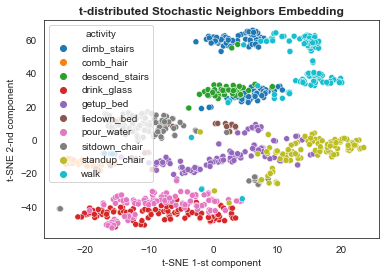

In [10]:
plotTSNE(X=scaledFts, y=trueLabels.values)

In [11]:
# split fts and labels into train and test set (stratifying by label as classes are unbalanced)
X_train, X_test, y_train, y_test = train_test_split(scaledFts,trueLabels,test_size=0.3,random_state=42,stratify=trueLabels)

In [12]:
classifiers = [
    KNeighborsClassifier(n_neighbors=len(activities)),
    SVC(kernel="rbf"),
    RandomForestClassifier(random_state=0),
    RidgeClassifier(max_iter=500),
    LogisticRegression(max_iter=500),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
]

In [13]:
f1ScoreClassifiers(X_train, X_test, y_train, y_test, classifiers, confusionMatrix=False)

F1-Score: 0.832,  Classifier: KNeighborsClassifier
F1-Score: 0.872,  Classifier: SVC
F1-Score: 0.895,  Classifier: RandomForestClassifier
F1-Score: 0.908,  Classifier: RidgeClassifier
F1-Score: 0.854,  Classifier: LogisticRegression
F1-Score: 0.77,  Classifier: GaussianNB
F1-Score: 0.911,  Classifier: LinearDiscriminantAnalysis


In [14]:
# build an ensemble classifier:
classifiersToStack = [
    ('SVC', SVC(kernel="rbf")),
    ('RFC', RandomForestClassifier(n_estimators=500, random_state=42)),
    ('RC', RidgeClassifier(max_iter=500)),
    ('LR', LogisticRegression(max_iter=500)),
    ('LDA', LinearDiscriminantAnalysis()),
]

f1ScoreEnsembleClassifier(X_train, X_test, y_train, y_test, classifiersTuplesLst=classifiersToStack)

Ensemble Classifier F1-Score: 0.913


### Repeat analysis using tsfresh to automatically extract and select time series features

In [15]:
# load all time series, automatically extract ans select features, store all in a matrix
dataMatrix = buildFeaturesDataMatrixUsingTSFresh(srcDir)

climb_stairs: Accelerometer-2011-03-24-10-24-39-climb_stairs-f1.txt
climb_stairs: Accelerometer-2011-03-24-10-25-44-climb_stairs-f1.txt
climb_stairs: Accelerometer-2011-03-29-09-55-46-climb_stairs-f1.txt
climb_stairs: Accelerometer-2011-04-05-18-21-22-climb_stairs-f1.txt
climb_stairs: Accelerometer-2011-04-05-18-32-29-climb_stairs-f1.txt
climb_stairs: Accelerometer-2011-04-11-11-44-35-climb_stairs-f1.txt
climb_stairs: Accelerometer-2011-04-11-11-57-50-climb_stairs-f1.txt
climb_stairs: Accelerometer-2011-04-11-11-58-30-climb_stairs-f1.txt
climb_stairs: Accelerometer-2011-05-30-08-21-38-climb_stairs-f1.txt
climb_stairs: Accelerometer-2011-05-30-08-30-37-climb_stairs-f1.txt
climb_stairs: Accelerometer-2011-05-30-08-39-09-climb_stairs-f1.txt
climb_stairs: Accelerometer-2011-05-30-09-29-58-climb_stairs-f1.txt
climb_stairs: Accelerometer-2011-05-30-09-38-52-climb_stairs-f1.txt
climb_stairs: Accelerometer-2011-05-30-09-43-37-climb_stairs-f1.txt
climb_stairs: Accelerometer-2011-05-30-10-20-47-

descend_stairs: Accelerometer-2011-03-29-16-17-18-descend_stairs-f1.txt
descend_stairs: Accelerometer-2011-03-29-16-17-50-descend_stairs-f1.txt
descend_stairs: Accelerometer-2011-03-29-16-18-14-descend_stairs-f1.txt
descend_stairs: Accelerometer-2011-04-05-18-26-06-descend_stairs-f1.txt
descend_stairs: Accelerometer-2011-04-11-11-51-27-descend_stairs-f1.txt
descend_stairs: Accelerometer-2011-04-11-13-32-24-descend_stairs-f1.txt
descend_stairs: Accelerometer-2011-05-30-08-20-55-descend_stairs-f1.txt
descend_stairs: Accelerometer-2011-05-30-08-24-58-descend_stairs-f1.txt
descend_stairs: Accelerometer-2011-05-30-08-34-06-descend_stairs-f1.txt
descend_stairs: Accelerometer-2011-05-30-09-29-15-descend_stairs-f1.txt
descend_stairs: Accelerometer-2011-05-30-09-31-43-descend_stairs-f1.txt
descend_stairs: Accelerometer-2011-05-30-09-40-50-descend_stairs-f1.txt
descend_stairs: Accelerometer-2011-05-30-10-19-56-descend_stairs-m1.txt
descend_stairs: Accelerometer-2011-05-30-10-24-51-descend_stairs

drink_glass: Accelerometer-2012-05-29-16-44-12-drink_glass-f2.txt
drink_glass: Accelerometer-2012-05-29-16-48-07-drink_glass-f2.txt
drink_glass: Accelerometer-2012-05-29-17-11-01-drink_glass-m3.txt
drink_glass: Accelerometer-2012-05-29-17-20-28-drink_glass-m3.txt
drink_glass: Accelerometer-2012-05-30-19-51-49-drink_glass-f2.txt
drink_glass: Accelerometer-2012-05-30-19-53-19-drink_glass-f2.txt
drink_glass: Accelerometer-2012-05-30-19-53-49-drink_glass-f2.txt
drink_glass: Accelerometer-2012-05-30-19-54-48-drink_glass-f2.txt
drink_glass: Accelerometer-2012-05-30-19-57-08-drink_glass-m3.txt
drink_glass: Accelerometer-2012-05-30-19-58-10-drink_glass-m3.txt
drink_glass: Accelerometer-2012-05-30-19-58-44-drink_glass-m3.txt
drink_glass: Accelerometer-2012-05-30-19-59-40-drink_glass-m3.txt
drink_glass: Accelerometer-2012-05-30-21-48-13-drink_glass-m2.txt
drink_glass: Accelerometer-2012-05-30-21-48-45-drink_glass-m2.txt
drink_glass: Accelerometer-2012-05-30-22-10-16-drink_glass-m2.txt
drink_glas

liedown_bed: Accelerometer-2011-05-31-15-18-50-liedown_bed-f1.txt
liedown_bed: Accelerometer-2011-05-31-16-24-36-liedown_bed-f1.txt
liedown_bed: Accelerometer-2011-05-31-16-29-43-liedown_bed-f1.txt
liedown_bed: Accelerometer-2011-06-02-16-57-35-liedown_bed-f4.txt
liedown_bed: Accelerometer-2011-06-02-16-58-20-liedown_bed-f4.txt
liedown_bed: Accelerometer-2011-06-02-16-59-13-liedown_bed-f4.txt
liedown_bed: Accelerometer-2011-06-02-17-00-38-liedown_bed-f4.txt
liedown_bed: Accelerometer-2011-06-02-17-21-57-liedown_bed-m1.txt
pour_water: Accelerometer-2011-03-24-10-04-32-pour_water-f1.txt
pour_water: Accelerometer-2011-03-24-10-51-12-pour_water-f1.txt
pour_water: Accelerometer-2011-03-24-13-30-01-pour_water-f1.txt
pour_water: Accelerometer-2011-04-05-18-54-14-pour_water-f1.txt
pour_water: Accelerometer-2011-04-11-12-55-26-pour_water-f1.txt
pour_water: Accelerometer-2011-05-30-21-05-39-pour_water-f1.txt
pour_water: Accelerometer-2011-05-30-21-51-05-pour_water-m2.txt
pour_water: Acceleromete

sitdown_chair: Accelerometer-2011-06-02-16-21-36-sitdown_chair-f1.txt
sitdown_chair: Accelerometer-2011-06-02-16-43-56-sitdown_chair-f4.txt
sitdown_chair: Accelerometer-2011-06-02-16-44-37-sitdown_chair-f4.txt
sitdown_chair: Accelerometer-2011-06-02-16-45-19-sitdown_chair-f4.txt
sitdown_chair: Accelerometer-2011-06-02-16-46-07-sitdown_chair-f4.txt
sitdown_chair: Accelerometer-2011-06-02-16-46-43-sitdown_chair-f4.txt
sitdown_chair: Accelerometer-2011-06-02-16-53-58-sitdown_chair-f4.txt
sitdown_chair: Accelerometer-2011-06-02-16-54-34-sitdown_chair-f4.txt
sitdown_chair: Accelerometer-2011-06-02-16-55-35-sitdown_chair-f4.txt
sitdown_chair: Accelerometer-2011-06-02-17-04-59-sitdown_chair-f4.txt
sitdown_chair: Accelerometer-2011-06-02-17-05-36-sitdown_chair-f4.txt
sitdown_chair: Accelerometer-2011-06-02-17-25-34-sitdown_chair-m1.txt
sitdown_chair: Accelerometer-2011-06-02-17-26-23-sitdown_chair-m1.txt
sitdown_chair: Accelerometer-2011-06-02-17-27-18-sitdown_chair-m1.txt
sitdown_chair: Accel

standup_chair: Accelerometer-2011-12-05-09-48-17-standup_chair-f1.txt
standup_chair: Accelerometer-2011-12-05-09-50-23-standup_chair-f1.txt
standup_chair: Accelerometer-2011-12-05-09-52-58-standup_chair-f1.txt
standup_chair: Accelerometer-2011-12-05-09-55-36-standup_chair-f1.txt
standup_chair: Accelerometer-2011-12-11-08-09-59-standup_chair-f4.txt
standup_chair: Accelerometer-2011-12-11-08-11-36-standup_chair-f4.txt
standup_chair: Accelerometer-2011-12-11-08-12-46-standup_chair-f4.txt
standup_chair: Accelerometer-2011-12-11-08-13-41-standup_chair-f4.txt
standup_chair: Accelerometer-2011-12-11-08-14-55-standup_chair-f4.txt
standup_chair: Accelerometer-2011-12-11-08-15-55-standup_chair-f4.txt
standup_chair: Accelerometer-2011-12-11-08-19-06-standup_chair-m2.txt
standup_chair: Accelerometer-2011-12-11-08-19-58-standup_chair-m2.txt
standup_chair: Accelerometer-2011-12-11-08-20-56-standup_chair-m2.txt
standup_chair: Accelerometer-2011-12-11-08-22-05-standup_chair-m2.txt
standup_chair: Accel

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 30/30 [03:58<00:00,  7.94s/it]


In [16]:
# prepare data:
trueLabels = dataMatrix['activity']
fts = dataMatrix.drop(labels='activity', axis=1).astype(float)
fts.shape

(806, 1962)

In [17]:
# print names of the selected tsfresh features:
fts.columns

Index(['x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0',
       'x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"',
       'z__abs_energy', 'x__agg_autocorrelation__f_agg_"mean"__maxlag_40',
       'z__quantile__q_0.7', 'z__root_mean_square',
       'x__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0',
       'x__autocorrelation__lag_9', 'x__quantile__q_0.1',
       'x__autocorrelation__lag_8',
       ...
       'z__fft_coefficient__attr_"real"__coeff_38',
       'z__partial_autocorrelation__lag_2',
       'y__fft_coefficient__attr_"angle"__coeff_16',
       'y__fft_coefficient__attr_"angle"__coeff_13',
       'z__fft_coefficient__attr_"angle"__coeff_73',
       'x__fft_coefficient__attr_"real"__coeff_36',
       'y__fft_coefficient__attr_"imag"__coeff_32',
       'z__large_standard_deviation__r_0.2',
       'y__large_standard_deviation__r_0.1',
       'y__large_standard_deviation__r_0.15000000000000002'],
      dtype='object', length=1962)

In [18]:
# normalize features:
scaler = StandardScaler()
scaledFts = pd.DataFrame(data=scaler.fit_transform(fts), columns=fts.columns)

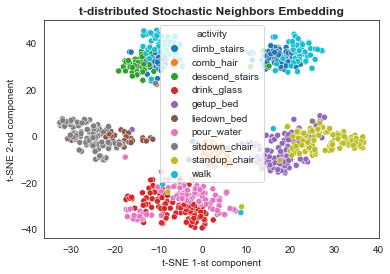

In [19]:
# t-SNE:
plotTSNE(X=scaledFts, y=trueLabels.values)

In [20]:
# split fts and labels into train and test set (stratifying by label as classes are unbalanced)
X_train, X_test, y_train, y_test = train_test_split(scaledFts, trueLabels, test_size=0.3, random_state=42, stratify=trueLabels)

In [21]:
# instantiate classifiers:
classifiers = [
    KNeighborsClassifier(n_neighbors=len(activities)),
    SVC(kernel="rbf"),
    RandomForestClassifier(n_estimators=500, random_state=42),
    RidgeClassifier(max_iter=500),
    LogisticRegression(max_iter=500),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
]

# run classification and return F1-score of each classifier:
f1ScoreClassifiers(X_train, X_test, y_train, y_test, classifiers, confusionMatrix=False)

F1-Score: 0.81,  Classifier: KNeighborsClassifier
F1-Score: 0.886,  Classifier: SVC
F1-Score: 0.923,  Classifier: RandomForestClassifier
F1-Score: 0.835,  Classifier: RidgeClassifier
F1-Score: 0.914,  Classifier: LogisticRegression
F1-Score: 0.744,  Classifier: GaussianNB
F1-Score: 0.903,  Classifier: LinearDiscriminantAnalysis


In [22]:
# build an ensemble classifier:
classifiersToStack = [
    ('SVC', SVC(kernel="rbf")),
    ('RFC', RandomForestClassifier(n_estimators=500, random_state=42)),
    ('RC', RidgeClassifier(max_iter=500)),
    ('LR', LogisticRegression(max_iter=500)),
    ('LDA', LinearDiscriminantAnalysis()),
]
f1ScoreEnsembleClassifier(X_train, X_test, y_train, y_test, classifiersTuplesLst=classifiersToStack)

Ensemble Classifier F1-Score: 0.954
